In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (12, 9)

In [199]:
geo = pd.read_excel(r'C:\Users\79531\ML Нетология\Занятие 13 Кластеризация\geo.xlsx')
geo.head()

,Unnamed: 0,x,y,comment_class
0,0,37.612416,55.777454,-1
1,1,37.612416,55.777454,-1
2,2,37.603298,55.742108,-1
3,3,37.558526,55.728758,-1
4,4,37.566431,55.731794,-1


In [200]:
geo.drop('Unnamed: 0', axis = 1, inplace = True)

In [201]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

## KMeans

In [202]:
# выполним кластеризацию только по районам
data_dictrict = geo.iloc[:,0:2]
X = np.nan_to_num(data_dictrict)

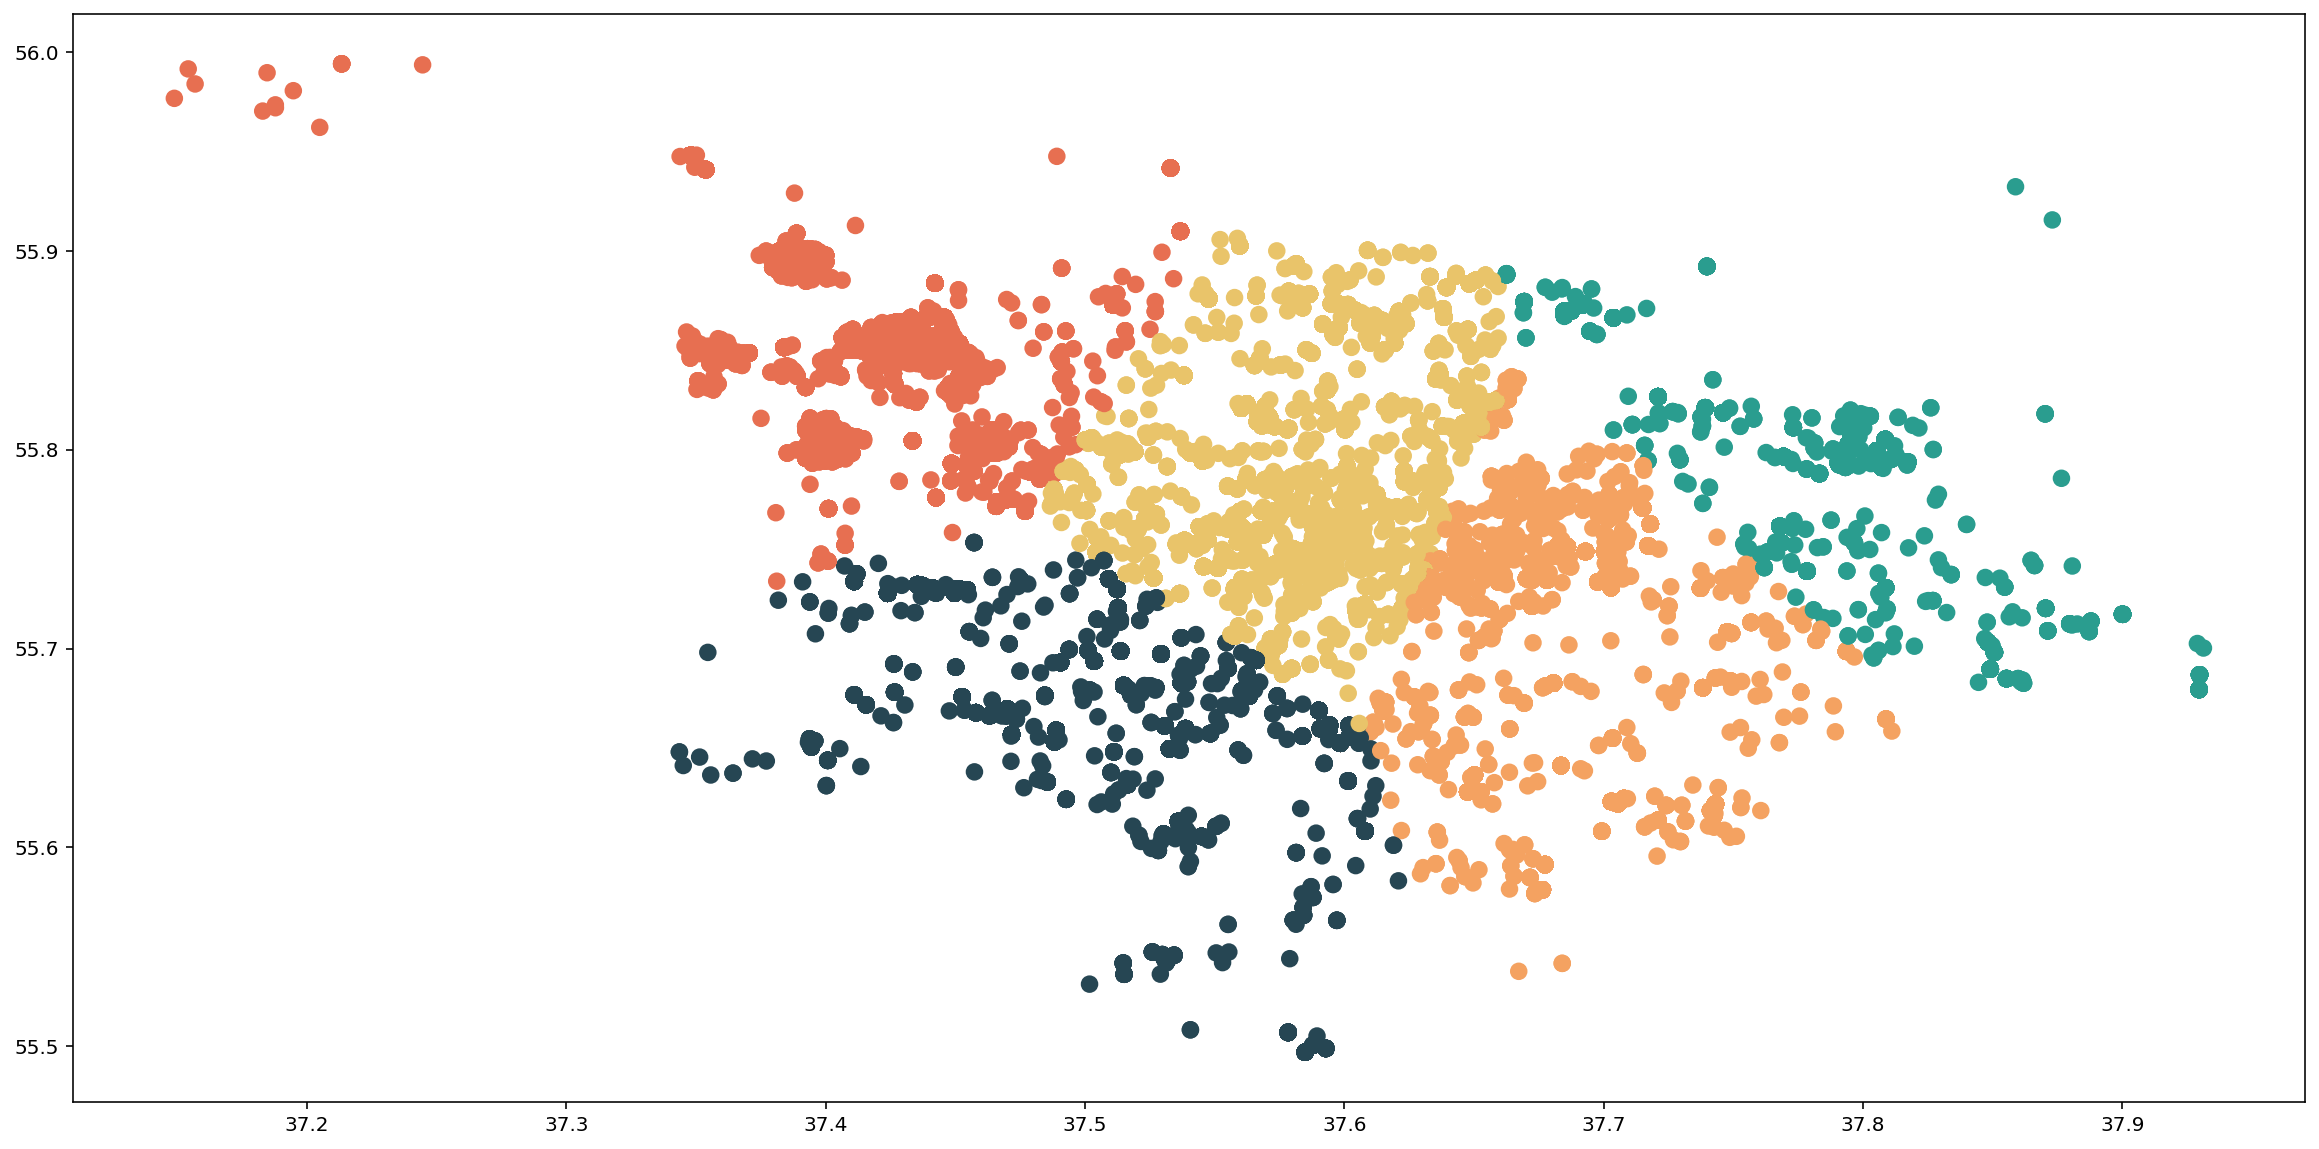

In [203]:
# пусть количество кластеров будет = 5, назначим также каждому кластеру цвет для идентификации
fig, ax = plt.subplots(figsize=(20, 10))
clusterNum = 5
k_means = KMeans(init = 'k-means++', n_clusters = clusterNum, max_iter = 60, random_state = 2021)
k_means.fit(X)
clusters_district = k_means.labels_
LABEL_COLOR_MAP = {0 : '#264653', # черные
                   1 : '#2a9d8f', # зеленые
                   2 : '#e9c46a', # желтые
                   3 : '#f4a261', # оранжевые
                   4 : '#e76f51', # красные
                  }
label_color = [LABEL_COLOR_MAP[l] for l in clusters_district]
ax.scatter(X[:, 0], X[:, 1], c=label_color, cmap='winter', s=60)

In [204]:
# добавим полученные метки кластеров для каждого наблюдения
geo['cluster_district'] = clusters_district

In [205]:
# посмотрим, как распределилось соотношение проголосовавших за и против по районам, для этого разделим переменную comment_class
geo_dum = pd.get_dummies(geo['comment_class'])
geo_dum.columns

Int64Index([-1, 1], dtype='int64')

In [206]:
geo['comment_-1'] = data_dum[-1]

In [207]:
geo['comment_+1'] = data_dum[1]

In [208]:
pivot_geo = geo.groupby('cluster_district').agg({'comment_-1' : 'sum', 'comment_+1' : 'sum'})
pivot_geo

,comment_-1,comment_+1
cluster_district,,
0,22024.0,198.0
1,8080.0,3925.0
2,23637.0,5575.0
3,18628.0,971.0
4,22778.0,2990.0


In [209]:
pivot_geo['share_positive'] = pivot_geo['comment_+1'] / (pivot_geo['comment_-1'] + pivot_geo['comment_+1'])

In [210]:
# видим, что высокие доли людей, проголосовавших за, находится в районах 1 (33%) (зеленые) и 2 (19%) (желтые).
# в районе 0 (черные) доля проголосовавших за менее 1%, в районе 3 (оранжевые) доля проголосовавших за также низкая и составляет
# менее 5%
pivot_geo

,comment_-1,comment_+1,share_positive
cluster_district,,,
0,22024.0,198.0,0.008910
1,8080.0,3925.0,0.326947
2,23637.0,5575.0,0.190846
3,18628.0,971.0,0.049543
4,22778.0,2990.0,0.116035


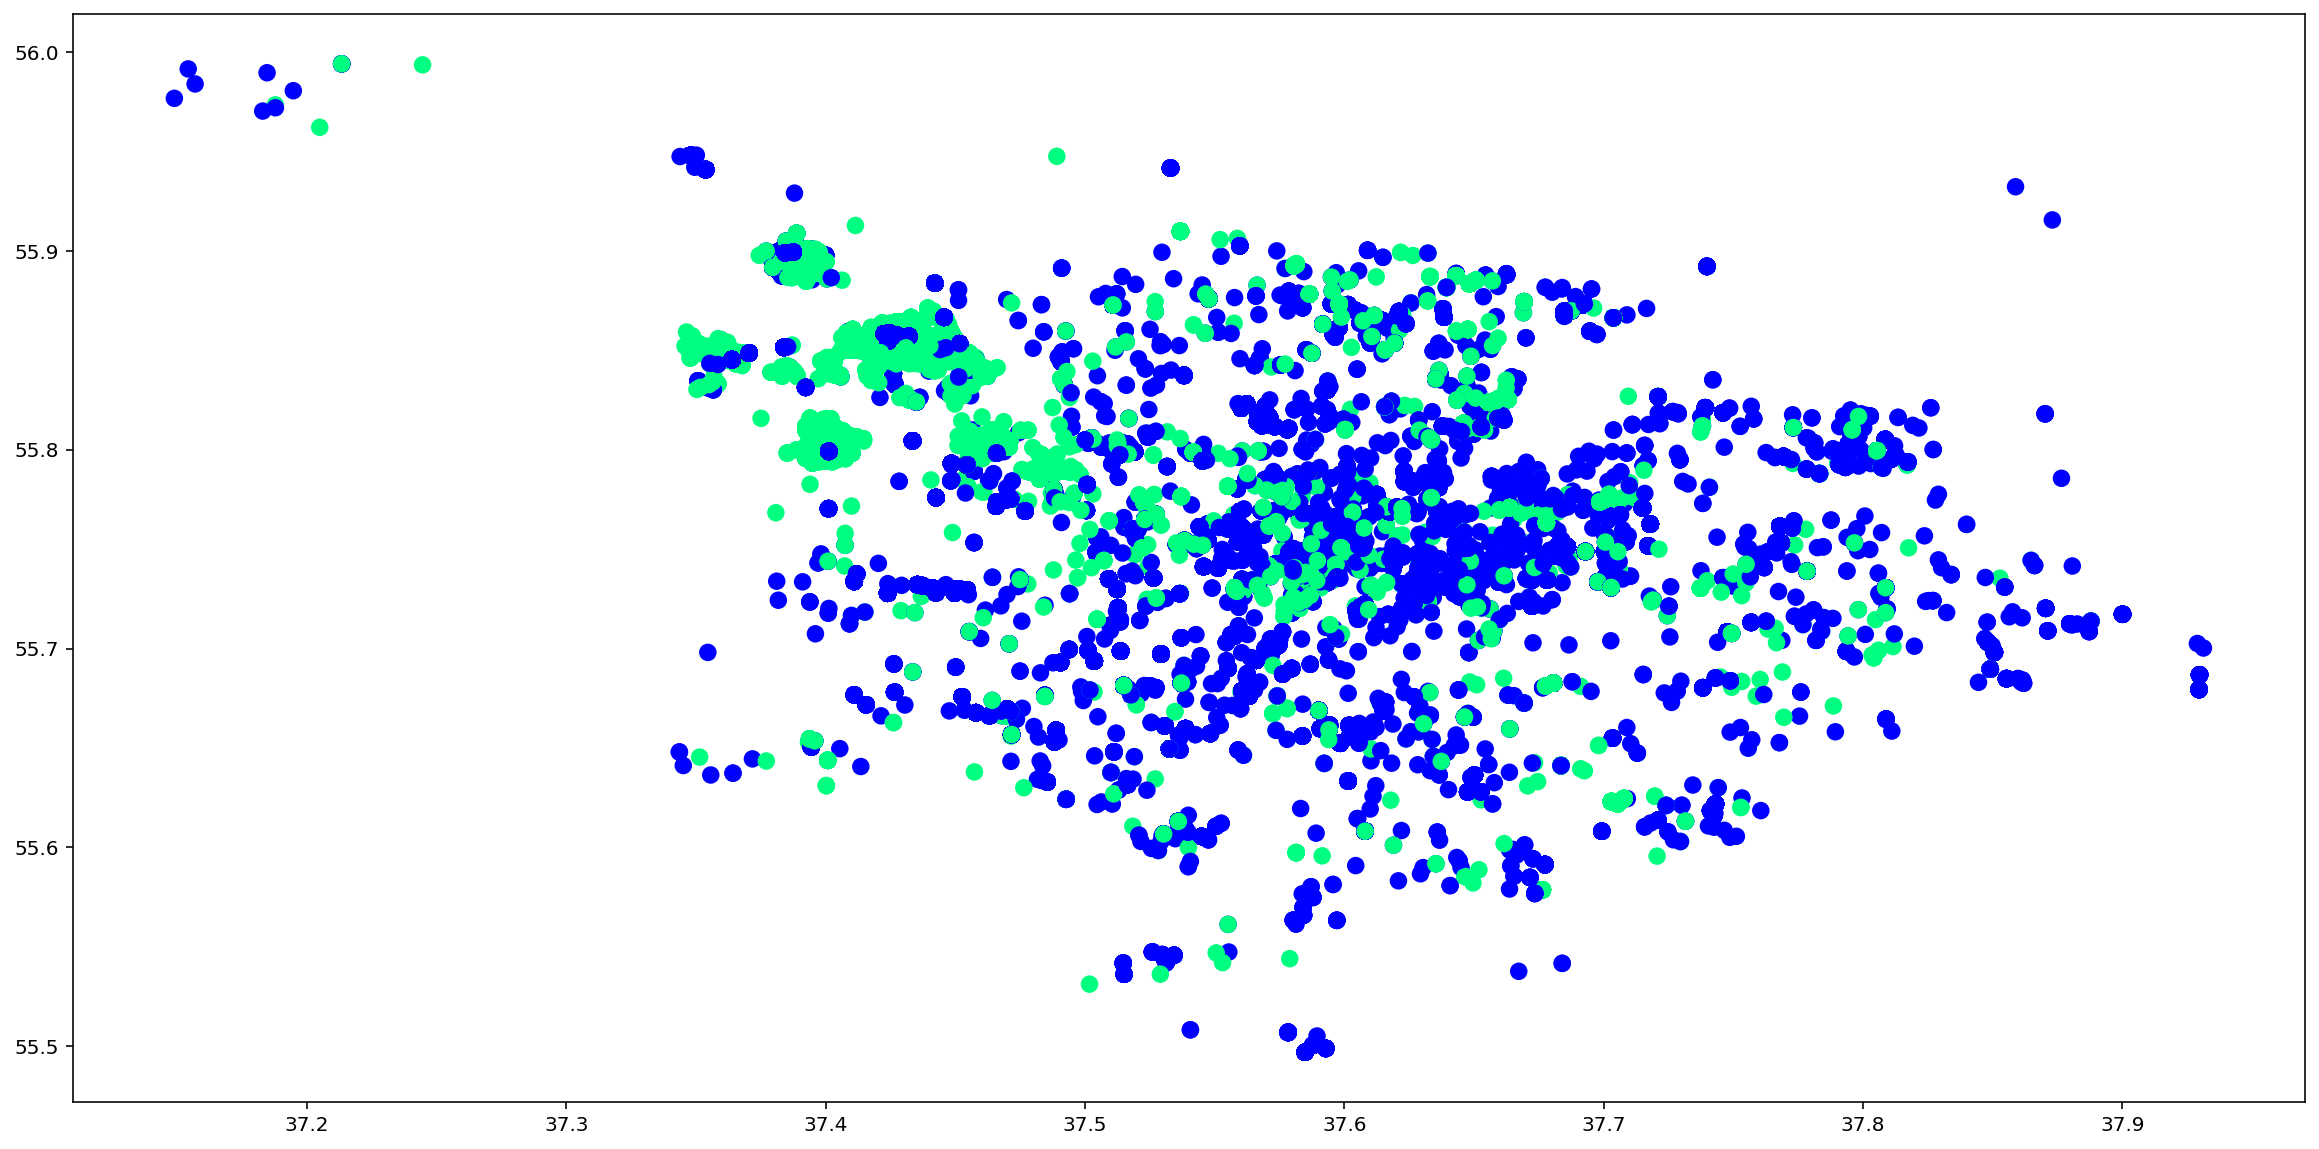

In [211]:
# посмотрим в целом на распредедение людей, проголосовавших за. Увидим, что их плотность наиболее высокая там, 
# где были выделены районы 1 и 2
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(X[:, 0], X[:, 1], c=geo['comment_class'], cmap='winter', s=60)

In [212]:
geo.drop('comment_class', axis = 1, inplace = True)

In [213]:
# теперь проведем кластеризацию с учетом признака comment
geo_comment = geo[['x', 'y','comment_-1', 'comment_+1']]

In [214]:
# стандартизируем переменные, так как они имеют разный масштаб измерений
X_comment = np.nan_to_num(geo_comment)
X_st = StandardScaler().fit_transform(X_comment)

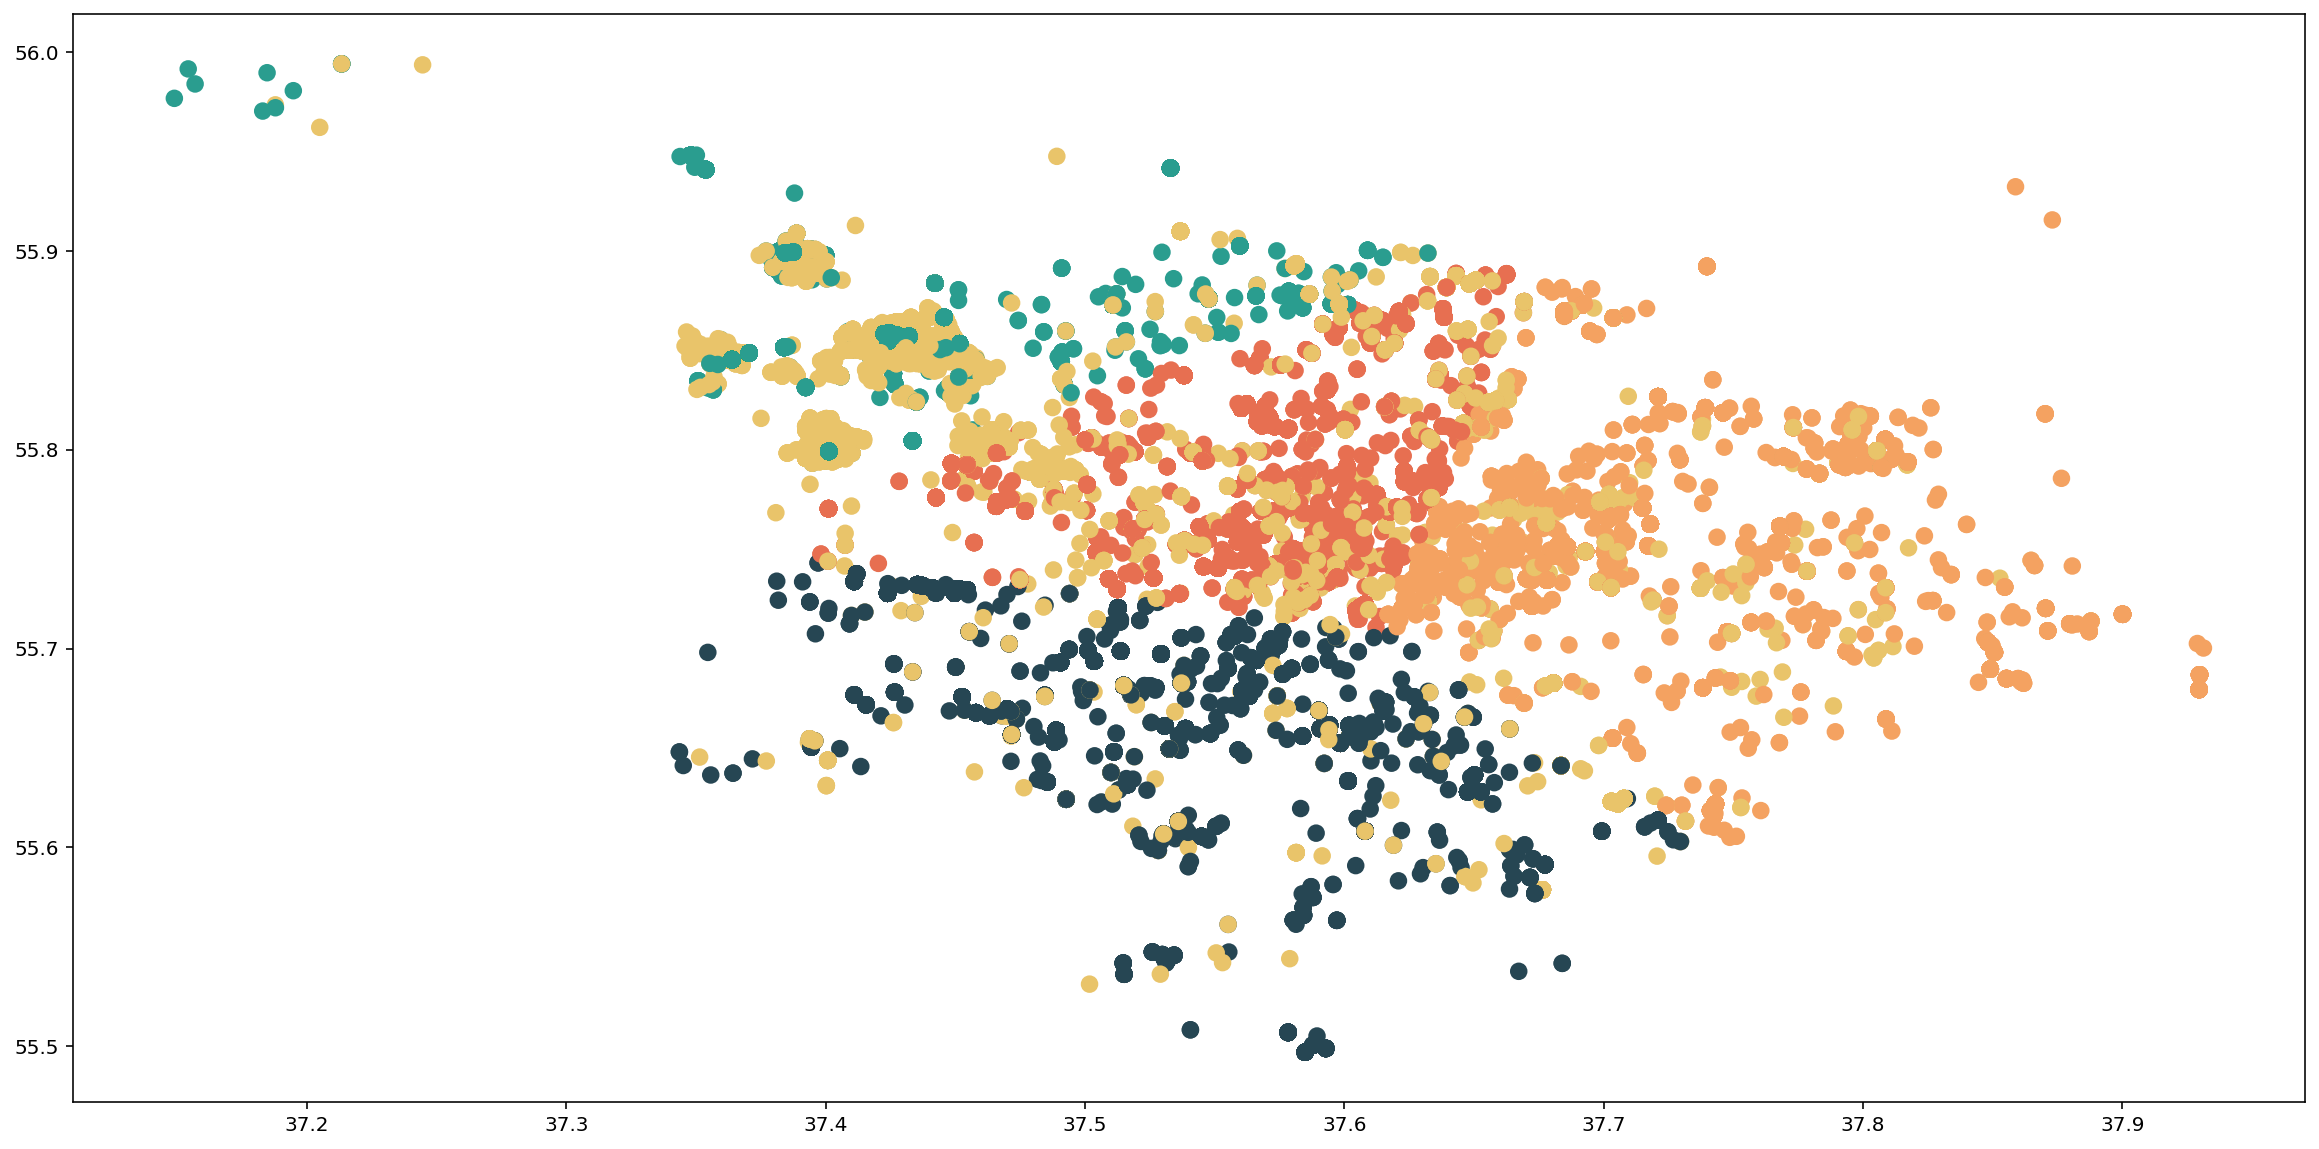

In [215]:
fig, ax = plt.subplots(figsize=(20, 10))
clusterNum = 5
k_means = KMeans(init = 'k-means++', n_clusters = clusterNum, max_iter = 60, random_state = 2021)
k_means.fit(X_st)
clusters_comment = k_means.labels_
LABEL_COLOR_MAP = {0 : '#264653', # черные
                   1 : '#2a9d8f', # зеленые
                   2 : '#e9c46a', # желтые
                   3 : '#f4a261', # оранжевые
                   4 : '#e76f51', # красные
                  }
label_color = [LABEL_COLOR_MAP[l] for l in clusters_comment]
ax.scatter(X_comment[:, 0], X_comment[:, 1], c=label_color, cmap='winter', s=60)

In [216]:
geo['clusters_comment'] = clusters_comment

In [217]:
# при кластеризации с учетом признака комментария за / против все объекты с признаком "за" попали в кластер 2 "желтые"
pivot_geo2 = geo.groupby('clusters_comment').agg({'comment_-1' : 'sum', 'comment_+1' : 'sum'})
pivot_geo2

,comment_-1,comment_+1
clusters_comment,,
0,21944.0,0.0
1,17352.0,0.0
2,0.0,13659.0
3,26479.0,0.0
4,29372.0,0.0


## Определение оптимального количества кластеров

In [218]:
#определим кол-во кластеров для районов
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_st, )
    k_inertia.append(clf_kmeans.inertia_)

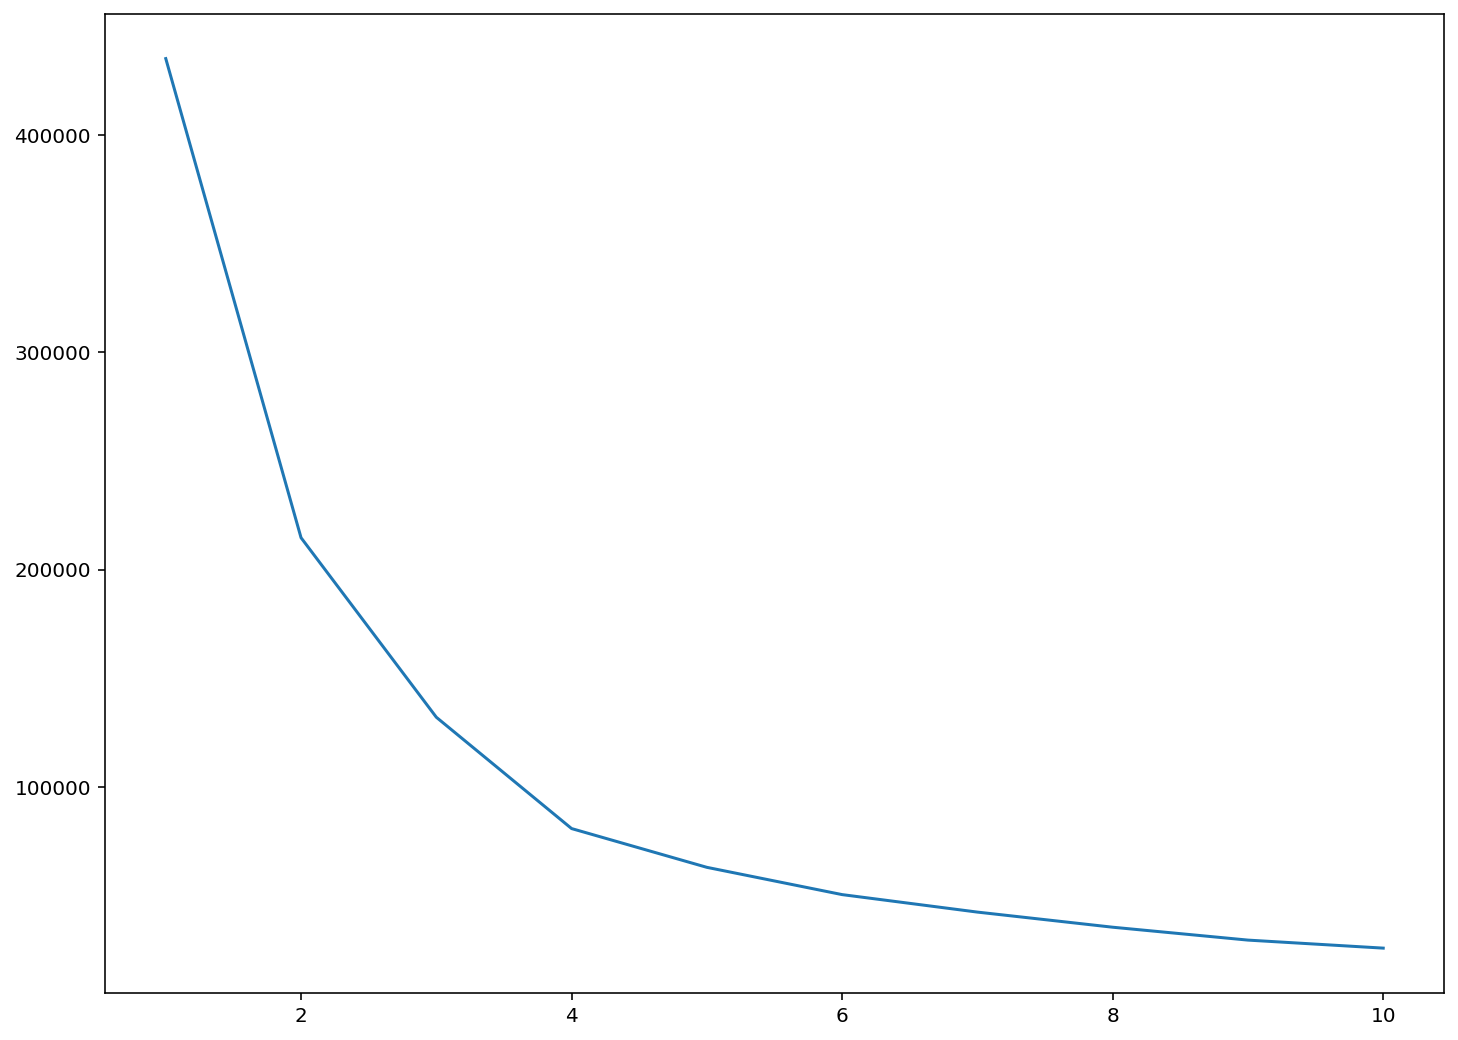

In [219]:
plt.plot(ks, k_inertia)

In [220]:
diff = np.diff(k_inertia)

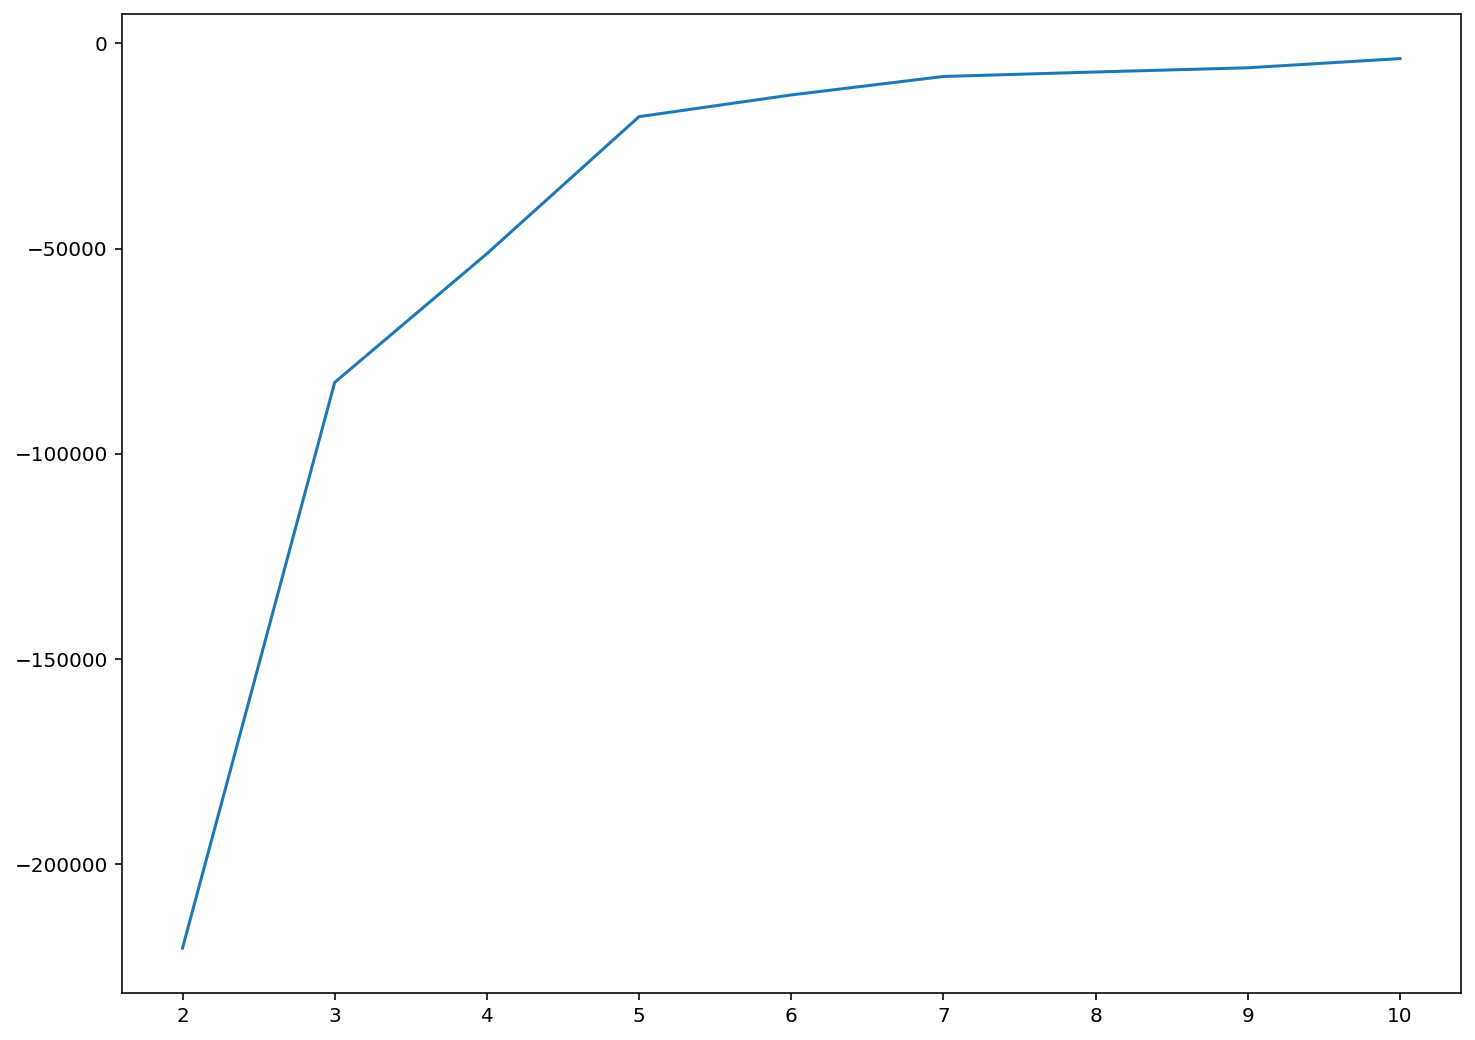

In [221]:
plt.plot(ks[1:], diff)

In [222]:
diff_r = diff[1:] / diff[:-1]

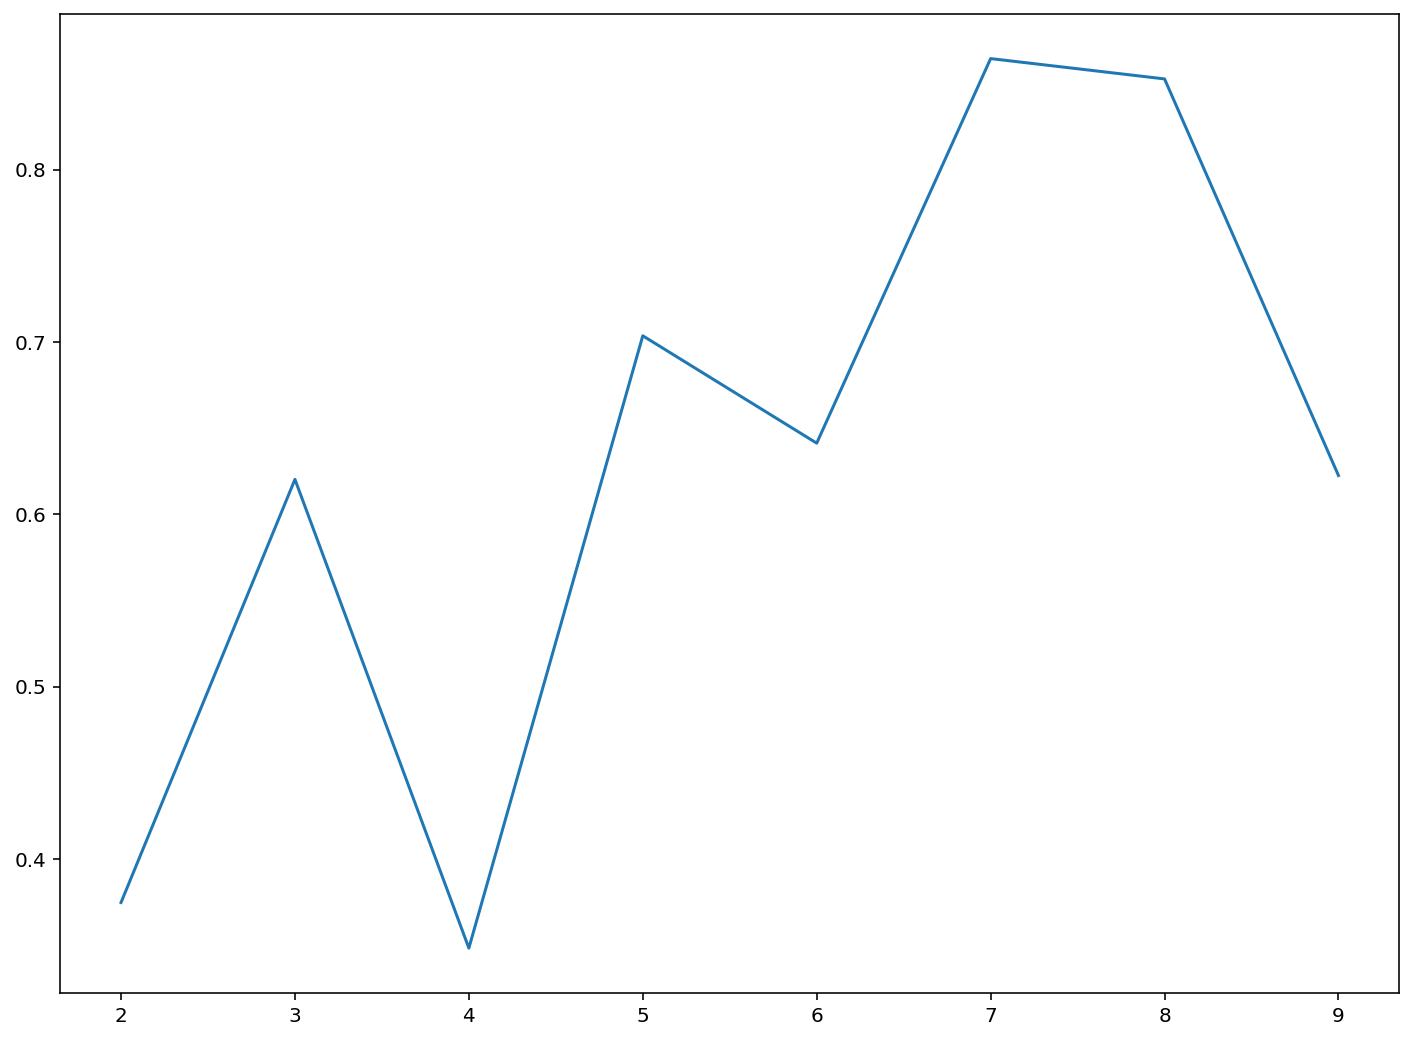

In [223]:
plt.plot(ks[1:-1], diff_r)

In [224]:
# таким образом, оптимальное количество кластеров = 4, т.е. при 4 кластерах сумма кв. отклонений от центроидов кластеров будет минимальной
k_opt = ks[np.argmin(diff_r)+1]
k_opt

4

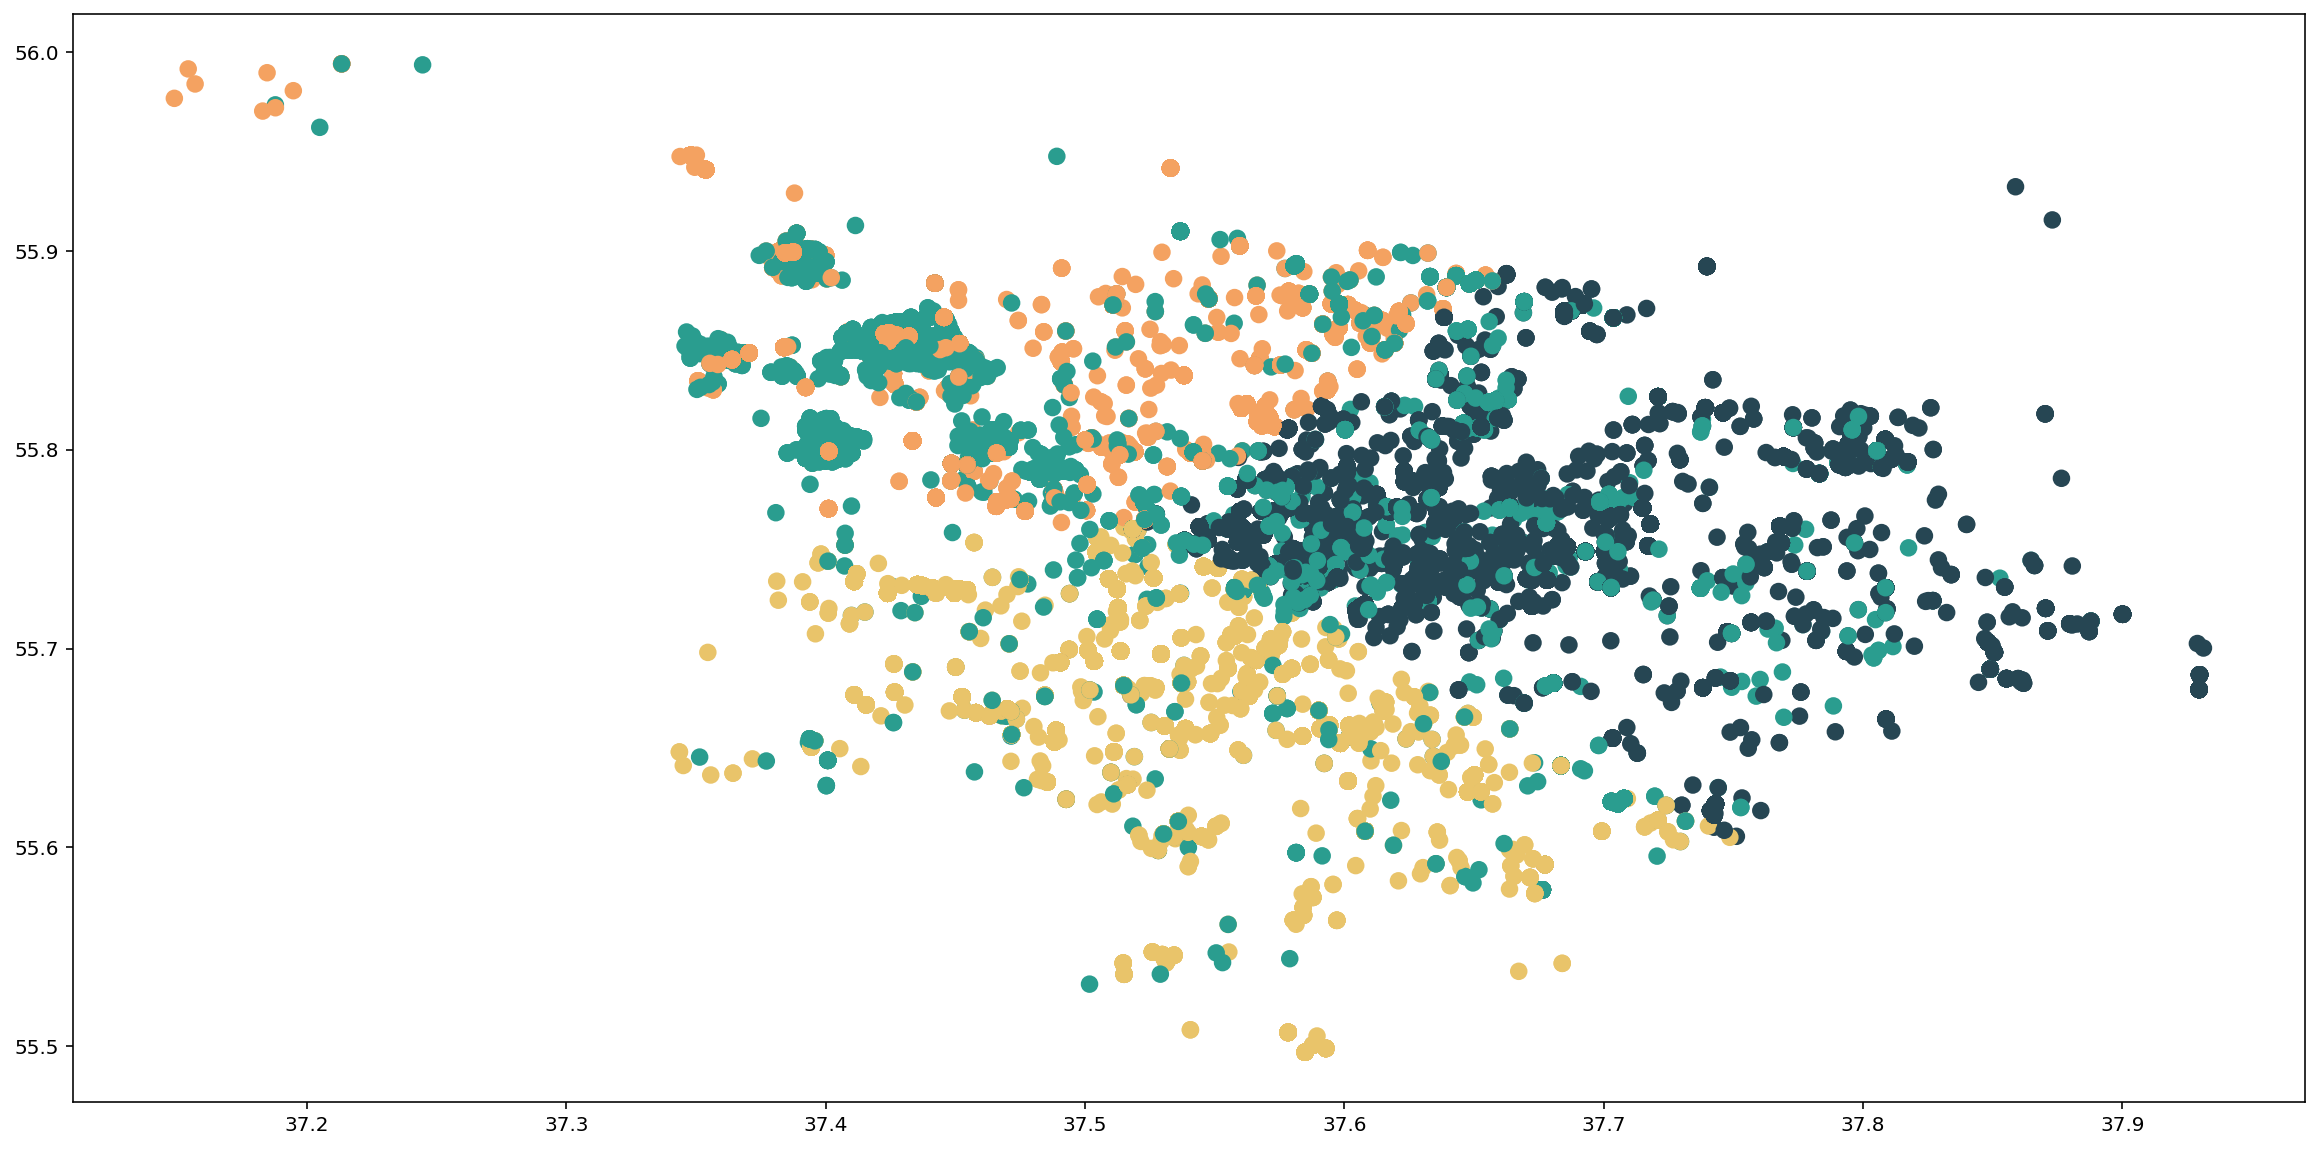

In [225]:
# повторим кластеризацию для всех признаков с учетом оптимального количества кластеров
fig, ax = plt.subplots(figsize=(20, 10))
clusterNum = 4
k_means = KMeans(init = 'k-means++', n_clusters = clusterNum, max_iter = 60, random_state = 2021)
k_means.fit(X_st)
clusters_comment = k_means.labels_
LABEL_COLOR_MAP = {0 : '#264653', # черные
                   1 : '#2a9d8f', # зеленые
                   2 : '#e9c46a', # желтые
                   3 : '#f4a261', # оранжевые
                   4 : '#e76f51', # красные
                  }
label_color = [LABEL_COLOR_MAP[l] for l in clusters_comment]
ax.scatter(X_comment[:, 0], X_comment[:, 1], c=label_color, cmap='winter', s=60)

In [226]:
geo['clusters_comment'] = clusters_comment
pivot_geo2 = geo.groupby('clusters_comment').agg({'comment_-1' : 'sum', 'comment_+1' : 'sum'})
pivot_geo2

,comment_-1,comment_+1
clusters_comment,,
0,41875.0,0.0
1,0.0,13659.0
2,24303.0,0.0
3,28969.0,0.0


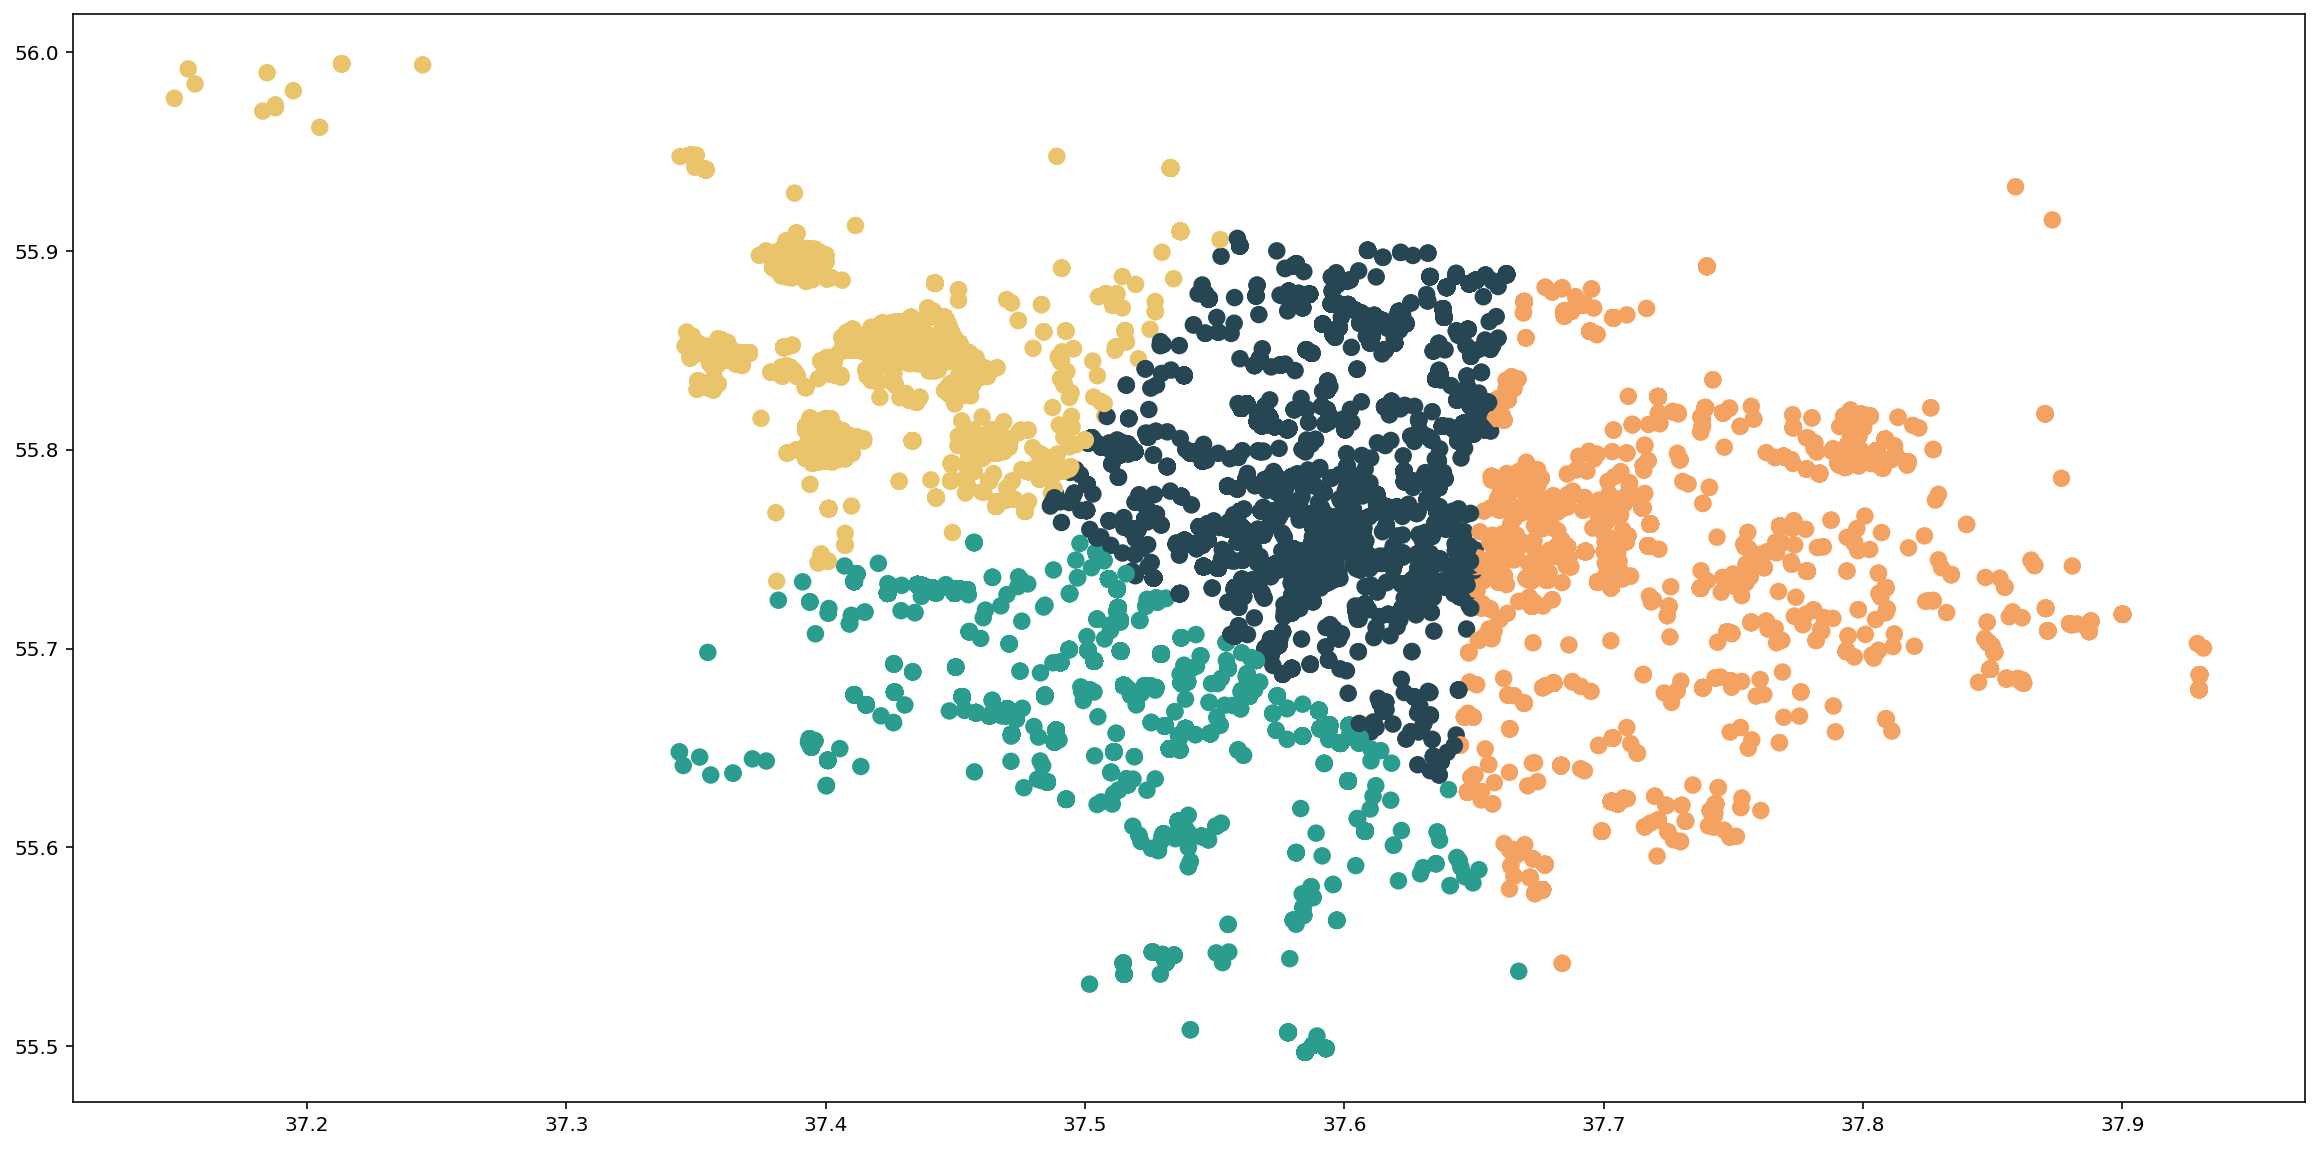

In [227]:
# повторим кластеризацию для районов с учетом оптимального количества кластеров
fig, ax = plt.subplots(figsize=(20, 10))
clusterNum = 4
k_means = KMeans(init = 'k-means++', n_clusters = clusterNum, max_iter = 60, random_state = 2021)
k_means.fit(X)
clusters_district = k_means.labels_
LABEL_COLOR_MAP = {0 : '#264653', # черные
                   1 : '#2a9d8f', # зеленые
                   2 : '#e9c46a', # желтые
                   3 : '#f4a261', # оранжевые
                   4 : '#e76f51', # красные
                  }
label_color = [LABEL_COLOR_MAP[l] for l in clusters_district]
ax.scatter(X[:, 0], X[:, 1], c=label_color, cmap='winter', s=60)

In [228]:
geo['cluster_district'] = clusters_district
pivot_geo = geo.groupby('cluster_district').agg({'comment_-1' : 'sum', 'comment_+1' : 'sum'})
pivot_geo['share_positive'] = pivot_geo['comment_+1'] / (pivot_geo['comment_-1'] + pivot_geo['comment_+1'])
pivot_geo

,comment_-1,comment_+1,share_positive
cluster_district,,,
0,23329.0,5525.0,0.191481
1,22250.0,207.0,0.009218
2,23294.0,3025.0,0.114936
3,26274.0,4902.0,0.157236


### вывод: на мой взгляд, лучший результат с точки зрения интерпретации дает кластеризация только по районам, а затем подсчет количества проголосовавших "за" и "против" в каждом районе. Тогда мы видим, что есть 1 район, в которых доли проголосовавших "за" существенно выше, чем во всех остальных районах. Так же, на мой взгляд, количество кластеров 5 было более удачным чем оптимальное 4, потому что при 5 кластерах очевидно было видна разница в плотности распределения положительно проголосовавших по районам. Например, был кластер с самой высокой долей (32%), два с достаточно высокой (19% и 12%) и два кластера с несущественной долей положительных комментарией (менее 1% и 5%). При раздедении на 4 кластера, в трех из них доля положительно проголосовавших приблизительно одинаковая. 